Data untuk provinsi Jawa Timur sebelum diproses:
       provinsi  jumlah  tahun
14   Jawa Timur  16.048   2022
49   Jawa Timur   0.000   2021
84   Jawa Timur  35.152   2020
119  Jawa Timur  35.706   2019
154  Jawa Timur  35.270   2018
189  Jawa Timur  35.270   2017
224  Jawa Timur  27.323   2016
259  Jawa Timur  27.323   2015

TimeSeries untuk provinsi Jawa Timur sebelum diproses:
2022    16.048
2021     0.000
2020    35.152
2019    35.706
2018    35.270
2017    35.270
2016    27.323
2015    27.323
dtype: float64


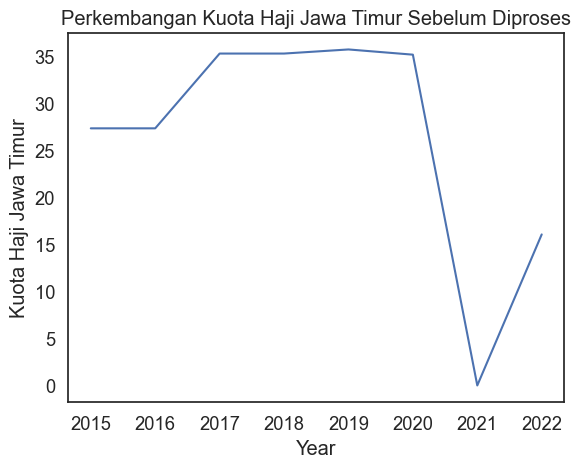

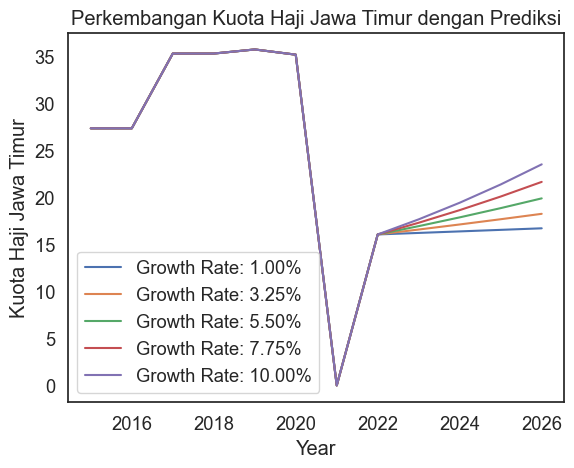

Hasil prediksi untuk provinsi Jawa Timur
Growth Rate: 1.00%, Prediksi Kuota Tahun 2027: 16.867
Growth Rate: 1.00%, Prediksi Kuota Tahun 2028: 17.035
Growth Rate: 1.00%, Prediksi Kuota Tahun 2029: 17.206
Growth Rate: 1.00%, Prediksi Kuota Tahun 2030: 17.378
Growth Rate: 1.00%, Prediksi Kuota Tahun 2031: 17.551
Growth Rate: 3.25%, Prediksi Kuota Tahun 2027: 18.831
Growth Rate: 3.25%, Prediksi Kuota Tahun 2028: 19.443
Growth Rate: 3.25%, Prediksi Kuota Tahun 2029: 20.075
Growth Rate: 3.25%, Prediksi Kuota Tahun 2030: 20.727
Growth Rate: 3.25%, Prediksi Kuota Tahun 2031: 21.401
Growth Rate: 5.50%, Prediksi Kuota Tahun 2027: 20.974
Growth Rate: 5.50%, Prediksi Kuota Tahun 2028: 22.128
Growth Rate: 5.50%, Prediksi Kuota Tahun 2029: 23.345
Growth Rate: 5.50%, Prediksi Kuota Tahun 2030: 24.629
Growth Rate: 5.50%, Prediksi Kuota Tahun 2031: 25.983
Growth Rate: 7.75%, Prediksi Kuota Tahun 2027: 23.308
Growth Rate: 7.75%, Prediksi Kuota Tahun 2028: 25.115
Growth Rate: 7.75%, Prediksi Kuota Tahun 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from modsim import *
import folium
from folium import plugins

# Membaca data
data = pd.read_csv("Perkembangan Kuota Jemaah Haji Menurut Provinsi.csv")

# Fungsi untuk membuat TimeSeries dari data yang belum diproses
def make_time_series(data):
    time_series = TimeSeries()
    for index, row in data.iterrows():
        year = row['tahun']
        jumlah = row['jumlah']
        time_series[year] = jumlah
    return time_series

# Fungsi untuk filter data berdasarkan provinsi
def filter_data_by_province(data, province):
    return data[data['provinsi'] == province]

# Input dari pengguna untuk provinsi
province = input("Masukkan nama provinsi: ")

# Fungsi untuk filter data berdasarkan provinsi
data_provinsi = filter_data_by_province(data, province)

# Cetak data provinsi sebelum diproses
print("Data untuk provinsi", province, "sebelum diproses:")
print(data_provinsi)

# Buat TimeSeries dari data yang belum diproses
time_series_provinsi = make_time_series(data_provinsi)

# Cetak TimeSeries yang dibuat
print("\nTimeSeries untuk provinsi", province, "sebelum diproses:")
print(time_series_provinsi)

# Plot TimeSeries
plt.plot(time_series_provinsi)
plt.xlabel('Year')
plt.ylabel(f'Kuota Haji {province}')
plt.title(f'Perkembangan Kuota Haji {province} Sebelum Diproses')
plt.show()

# Menginisialisasi System
def make_system(data, growth_rate, pred_years):
    initial_year = data['tahun'].min()
    final_year = data['tahun'].max() + pred_years
    provinsi = data['provinsi'].unique()[0]
    
    return System(initial_year=initial_year,
                  final_year=final_year,
                  provinsi=provinsi,
                  growth_rate=growth_rate)

# Membuat State awal
def make_initial_state(system, data):
    initial_kuota = data[data['tahun'] == system.initial_year]['jumlah'].sum()
    return State(year=system.initial_year, kuota=initial_kuota)

# Update function untuk State
def update_state(state, system, t, data):
    current_year = int(t)
    yearly_data = data[data['tahun'] == current_year]
    
    if not yearly_data.empty:
        kuota = yearly_data['jumlah'].sum()
    else:
        if current_year <= system.final_year:
            kuota = state.kuota * (1 + system.growth_rate)
        else:
            return None  # Mengembalikan None untuk menandakan akhir iterasi
    
    return State(year=current_year, kuota=kuota)

# Membuat Timeseries
def run_simulation(system, initial_state, data):
    t_array = linrange(system.initial_year, system.final_year)
    results = TimeSeries()
    
    state = initial_state
    for t in t_array:
        state = update_state(state, system, t, data)
        if state is None:
            break  # Berhenti iterasi jika mencapai tahun terakhir yang diprediksi
        results[t] = state.kuota
    
    return results

# SweepSeries untuk mensimulasikan berbagai growth_rate
def simulate_province(data, province, growth_rates, pred_years):
    data_provinsi = filter_data_by_province(data, province)
    sweep = SweepSeries()
    
    for rate in growth_rates:
        system = make_system(data_provinsi, rate, pred_years)
        initial_state = make_initial_state(system, data_provinsi)
        results = run_simulation(system, initial_state, data_provinsi)
        sweep[rate] = results
    
    return sweep

# Parameter simulasi
pred_years = 5  # Jumlah tahun prediksi

# Input dari pengguna untuk provinsi dan growth rates yang diinginkan
province = input("Masukkan nama provinsi: ")
min_growth_rate = float(input("Masukkan growth rate minimum (misal, 0.01 untuk 1%): "))
max_growth_rate = float(input("Masukkan growth rate maksimum (misal, 0.1 untuk 10%): "))
num_growth_rates = int(input("Masukkan jumlah nilai growth rate yang diinginkan (misal, 5): "))

# Membuat linspace untuk growth rates
growth_rates = linspace(min_growth_rate, max_growth_rate, num_growth_rates)

# Jalankan simulasi untuk provinsi yang dipilih
sweep = simulate_province(data, province, growth_rates, pred_years)

# Plotting results
for rate, series in sweep.items():
    plt.plot(series, label=f'Growth Rate: {rate:.2%}')

plt.xlabel('Year')
plt.ylabel(f'Kuota Haji {province}')
plt.title(f'Perkembangan Kuota Haji {province} dengan Prediksi')
plt.legend()
plt.show()

# Cetak hasil prediksi
print("Hasil prediksi untuk provinsi", province)
for rate, series in sweep.items():
    final_year = int(series.index[-1])
    for i in range(1, 6):
        predicted_quota = series[final_year] * (1 + rate) ** i
        print(f'Growth Rate: {rate:.2%}, Prediksi Kuota Tahun {final_year + i}: {predicted_quota:.3f}')


## Penampilan Peta 

In [28]:
class Lokasi:
    def __init__(self, nama, longitude, latitude):
        self.nama = nama
        self.longitude = longitude
        self.latitude = latitude

lokasi_objek = [
    Lokasi("Aceh", 95.3213, 4.6951),
    Lokasi("Sumatera Utara", 99.1332, 2.1151),
    Lokasi("Sumatera Barat", 100.4658, -0.9516),
    Lokasi("Riau", 101.6842, 0.5121),
    Lokasi("Jambi", 102.3481, -1.6177),
    Lokasi("Sumatera Selatan", 104.7458, -3.3199),
    Lokasi("Bengkulu", 102.2594, -3.5778),
    Lokasi("Lampung", 105.3333, -4.5586),
    Lokasi("Kepulauan Bangka Belitung", 105.9869, -2.7411),
    Lokasi("Kepulauan Riau", 108.2022, 3.9456),
    Lokasi("DKI Jakarta", 106.8456, -6.2088),
    Lokasi("Jawa Barat", 107.621, -6.9345),
    Lokasi("Jawa Tengah", 110.0649, -7.155),
    Lokasi("DI Yogyakarta", 110.4262, -7.7975),
    Lokasi("Jawa Timur", 112.7325, -7.7237),
    Lokasi("Banten", 106.1091, -6.4058),
    Lokasi("Bali", 115.0901, -8.3405),
    Lokasi("Nusa Tenggara Barat", 116.1165, -8.650),
    Lokasi("Nusa Tenggara Timur", 121.5722, -8.6574),
    Lokasi("Kalimantan Barat", 111.3426, -0.2787),
    Lokasi("Kalimantan Tengah", 113.4246, -1.6815),
    Lokasi("Kalimantan Selatan", 115.5363, -3.3194),
    Lokasi("Kalimantan Timur", 116.0375, -0.4786),
    Lokasi("Kalimantan Utara", 116.4233, 2.9932),
    Lokasi("Sulawesi Utara", 124.8484, 0.5015),
    Lokasi("Sulawesi Tengah", 121.4457, -1.43),
    Lokasi("Sulawesi Selatan", 120.1617, -4.6784),
    Lokasi("Sulawesi Tenggara", 122.0789, -4.1449),
    Lokasi("Gorontalo", 123.0595, 0.6999),
    Lokasi("Maluku", 128.1816, -3.2385),
    Lokasi("Maluku Utara", 127.8088, 0.7904),
    Lokasi("Papua Barat", 132.4675, -1.3361),
    Lokasi("Papua", 138.8334, -4.2699)
]


## Pencarian lokasi berdasarkan objek diatas

In [33]:
provinsi_input = province

for lokasi in lokasi_objek:
    if lokasi.nama.lower() == provinsi_input.lower():
        print("Longitude:", lokasi.longitude)
        print("Latitude:", lokasi.latitude)
        break
else:
    print("Provinsi tidak ditemukan.")


Longitude: 112.7325
Latitude: -7.7237


## Pembuatan Pop up

In [32]:

# Cetak hasil prediksi
# print("Hasil prediksi untuk provinsi", province)
predicted_data = {}
for rate, series in sweep.items():
    final_year = int(series.index[-1])
    predicted_quota_list = []
    for i in range(1, 6):
        predicted_quota = series[final_year] * (1 + rate) ** i
        predicted_quota_list.append(predicted_quota)
        # print(f'Growth Rate: {rate:.2%}, Prediksi Kuota Tahun {final_year + i}: {predicted_quota:.3f}')
    predicted_data[rate] = predicted_quota_list
    
# Menyiapkan konten pop-up untuk peta
hasil = data[data['provinsi'] == province]
popup_content_awal = f"<strong>Hajj Quota for {province}</strong><br>"
for index, row in hasil.iterrows():
    popup_content_awal += f"{row['tahun']}: {row['jumlah']}<br>"

popup_content_akhir = f"<strong>Prediksi Haji {province}</strong><br>"
for rate, quotas in predicted_data.items():
    popup_content_akhir += f"Growth Rate: {rate:.2%}<br>"
    for i, quota in enumerate(quotas):
        popup_content_akhir += f"Tahun {final_year + i + 1}: {quota:.3f}<br>"

# Lokasi awal dan akhir (replace with actual coordinates)
lokasi_awal = [lokasi.latitude, lokasi.longitude]  # Replace with actual coordinates
lokasi_akhir = [21.422510, 39.826168]  # Example coordinates

# Membuat peta dengan lokasi awal sebagai titik pusat
peta = folium.Map(location=lokasi_awal, zoom_start=3)

# Menambahkan marker untuk lokasi awal dan akhir
folium.Marker(lokasi_awal, popup=folium.Popup(popup_content_awal, max_width=300)).add_to(peta)
folium.Marker(lokasi_akhir, popup=folium.Popup(popup_content_akhir, max_width=300)).add_to(peta)

# Menambahkan animasi pergerakan menggunakan AntPath
ant_path = plugins.AntPath(locations=[lokasi_awal, lokasi_akhir], delay=1000, color='blue')
ant_path.add_to(peta)


Hasil prediksi untuk provinsi Jawa Timur


## Print Peta

In [34]:
lokasi_awal = [lokasi.latitude, lokasi.longitude]

# Lokasi akhir
lokasi_akhir = [21.422510, 39.826168]

# Membuat peta dengan lokasi awal sebagai titik pusat
peta = folium.Map(location=lokasi_awal, zoom_start=3)

# Menambahkan marker untuk lokasi awal dan akhir
folium.Marker(lokasi_awal, popup=folium.Popup(popup_content_awal, max_width=300)).add_to(peta)
folium.Marker(lokasi_akhir, popup=folium.Popup(popup_content_akhir, max_width=300)).add_to(peta)

# Menambahkan animasi pergerakan menggunakan AntPath
ant_path = plugins.AntPath(locations=[lokasi_awal, lokasi_akhir], delay=1000, color='blue')
ant_path.add_to(peta)

# Menampilkan peta
peta